In [57]:
import equinox as eqx
import jax.numpy as jnp
import matplotlib.pyplot as plt

from chromatix.experimental.modified_born_series.sample import (
    EmptySample,
    Source,
    add_absorbing_bc,
)
from chromatix.experimental.modified_born_series.solver import solve

%config InlineBackend.figure_format='retina'

## Step-index fiber (single-refr for core and cladding)

In [58]:
wavelength = 0.625  # 0.5  # [mum]
material_core_refractive_index = 1.5
material_cladding_refractive_index = 1.4
n_background = 1.0
k0 = 2 * jnp.pi / wavelength
# grid_shape = [256, 256 * 4 // 3, 8]
grid_shape = [64, 128, 64]
spacing = wavelength / 2
mbs_thickness = 10.0 * wavelength
mbs_boundary_width = int(mbs_thickness / spacing)

material_cylinder_refr_diff_arr = [0.1, 0.4]
material_cylinder_radius_arr = [0.5, 1]

# Definining sample
sample = EmptySample(grid_shape, spacing)
refractive_index = sample.permittivity  # 0.0 at start
print("Pre-pad sample shape (x, y, z):")
print(sample.shape)

for i in range(len(material_cylinder_refr_diff_arr)):
    # dn = material_core_refractive_index - n_background
    object_radius = (sample.extent[0] / 2) / 2 * material_cylinder_radius_arr[i]
    object = (
        jnp.sqrt((sample.grid[..., 0] ** 2) + (sample.grid[..., 2] ** 2))
        < object_radius
    )
    # refractive_index = 1.0 + dn * object
    refractive_index += material_cylinder_refr_diff_arr[i] * object
refractive_index += n_background
sample = sample.replace(permittivity=refractive_index**2)

no_pad = False  # set at axis 1
# Add absorbing boundaries
# sample = add_absorbing_bc(sample, axis=(0, 1), thickness=2.0, max_extinction=0.25)
sample = add_absorbing_bc(
    sample, axis=(1), thickness=mbs_thickness, max_extinction=0.25
)
print("Post-pad sample shape (x, y, z):")
sample.shape

print("Core radius (px, um):")
print(
    str(material_cylinder_radius_arr[0] * object_radius)
    + " (px), "
    + str(material_cylinder_radius_arr[0] * object_radius * spacing)[:6]
)
print("Cladding radius (um):")
print(str(material_cylinder_radius_arr[1] * object_radius * spacing)[:6])

Pre-pad sample shape (x, y, z):
(64, 128, 64)
Post-pad sample shape (x, y, z):
Core radius (px, um):
2.5 (px), 0.7812
Cladding radius (um):
1.5625


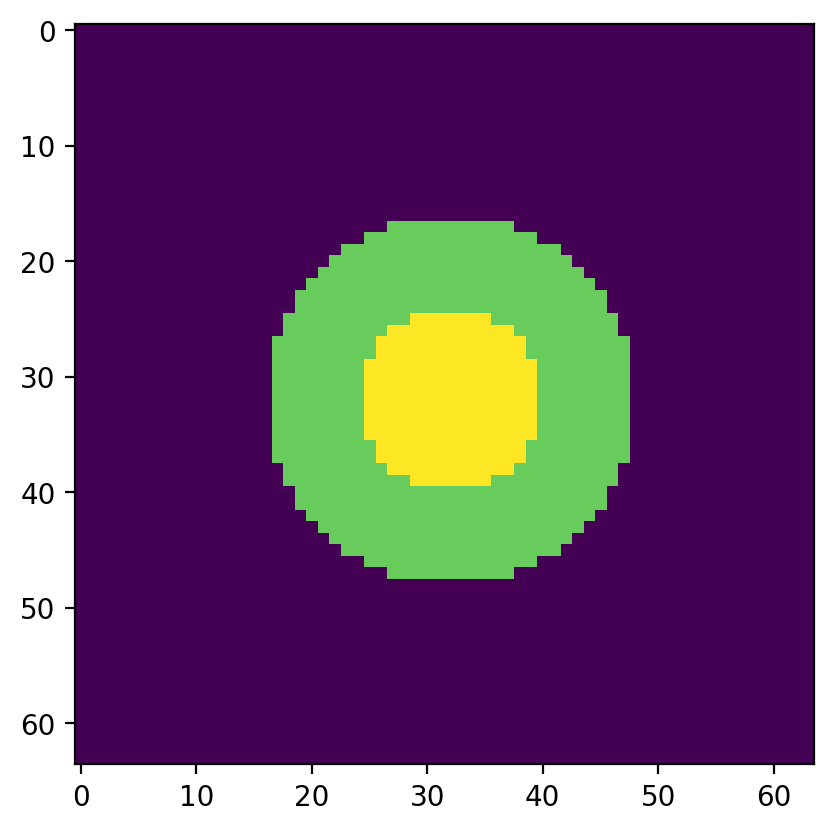

In [59]:
plt.imshow(sample.permittivity[:, 32, :].real)

## 'Continuous' version

In [60]:
if False:
    wavelength = 0.5  # [mum]

    k0 = 2 * jnp.pi / wavelength
    # grid_shape = [256, 256 * 4 // 3, 8]
    grid_shape = [64, 128, 64]
    spacing = wavelength / 2

    # --------
    m_core_refr = 1.5
    m_cladding_refr = 1.4
    m_core_radius_ratio = 0.1

    background_refr = 1.0

    num_steps = 2
    m_cylinder_refr_diff_arr = [
        (m_core_refr - m_cladding_refr) / num_steps
    ] * num_steps  # [0.1, 0.4]
    m_cylinder_refr_diff_arr[-1] = m_cladding_refr - background_refr
    m_cylinder_radius_arr = jnp.linspace(
        m_core_radius_ratio, 1.0, num_steps
    )  # [0.5, 1]

    # Definining sample
    sample = EmptySample(grid_shape, spacing)
    refractive_index = sample.permittivity  # 0.0 at start
    print(sample.grid.shape)

    for i in range(len(m_cylinder_refr_diff_arr)):
        # dn = material_core_refractive_index - n_background
        object_radius = (sample.extent[0] / 2) / 2 * m_cylinder_refr_diff_arr[i]
        object = (
            jnp.sqrt((sample.grid[..., 0] ** 2) + (sample.grid[..., 2] ** 2))
            < object_radius
        )
        # refractive_index = 1.0 + dn * object
        refractive_index += m_cylinder_refr_diff_arr[i] * object
    refractive_index += background_refr
    print(jnp.max(refractive_index))
    sample = sample.replace(permittivity=refractive_index**2)

    no_pad = False  # set at axis 1
    # Add absorbing boundaries
    # sample = add_absorbing_bc(sample, axis=(0, 1), thickness=2.0, max_extinction=0.25)
    sample = add_absorbing_bc(sample, axis=(1), thickness=2.0, max_extinction=0.25)

    sample.shape

## Show sample permittivity

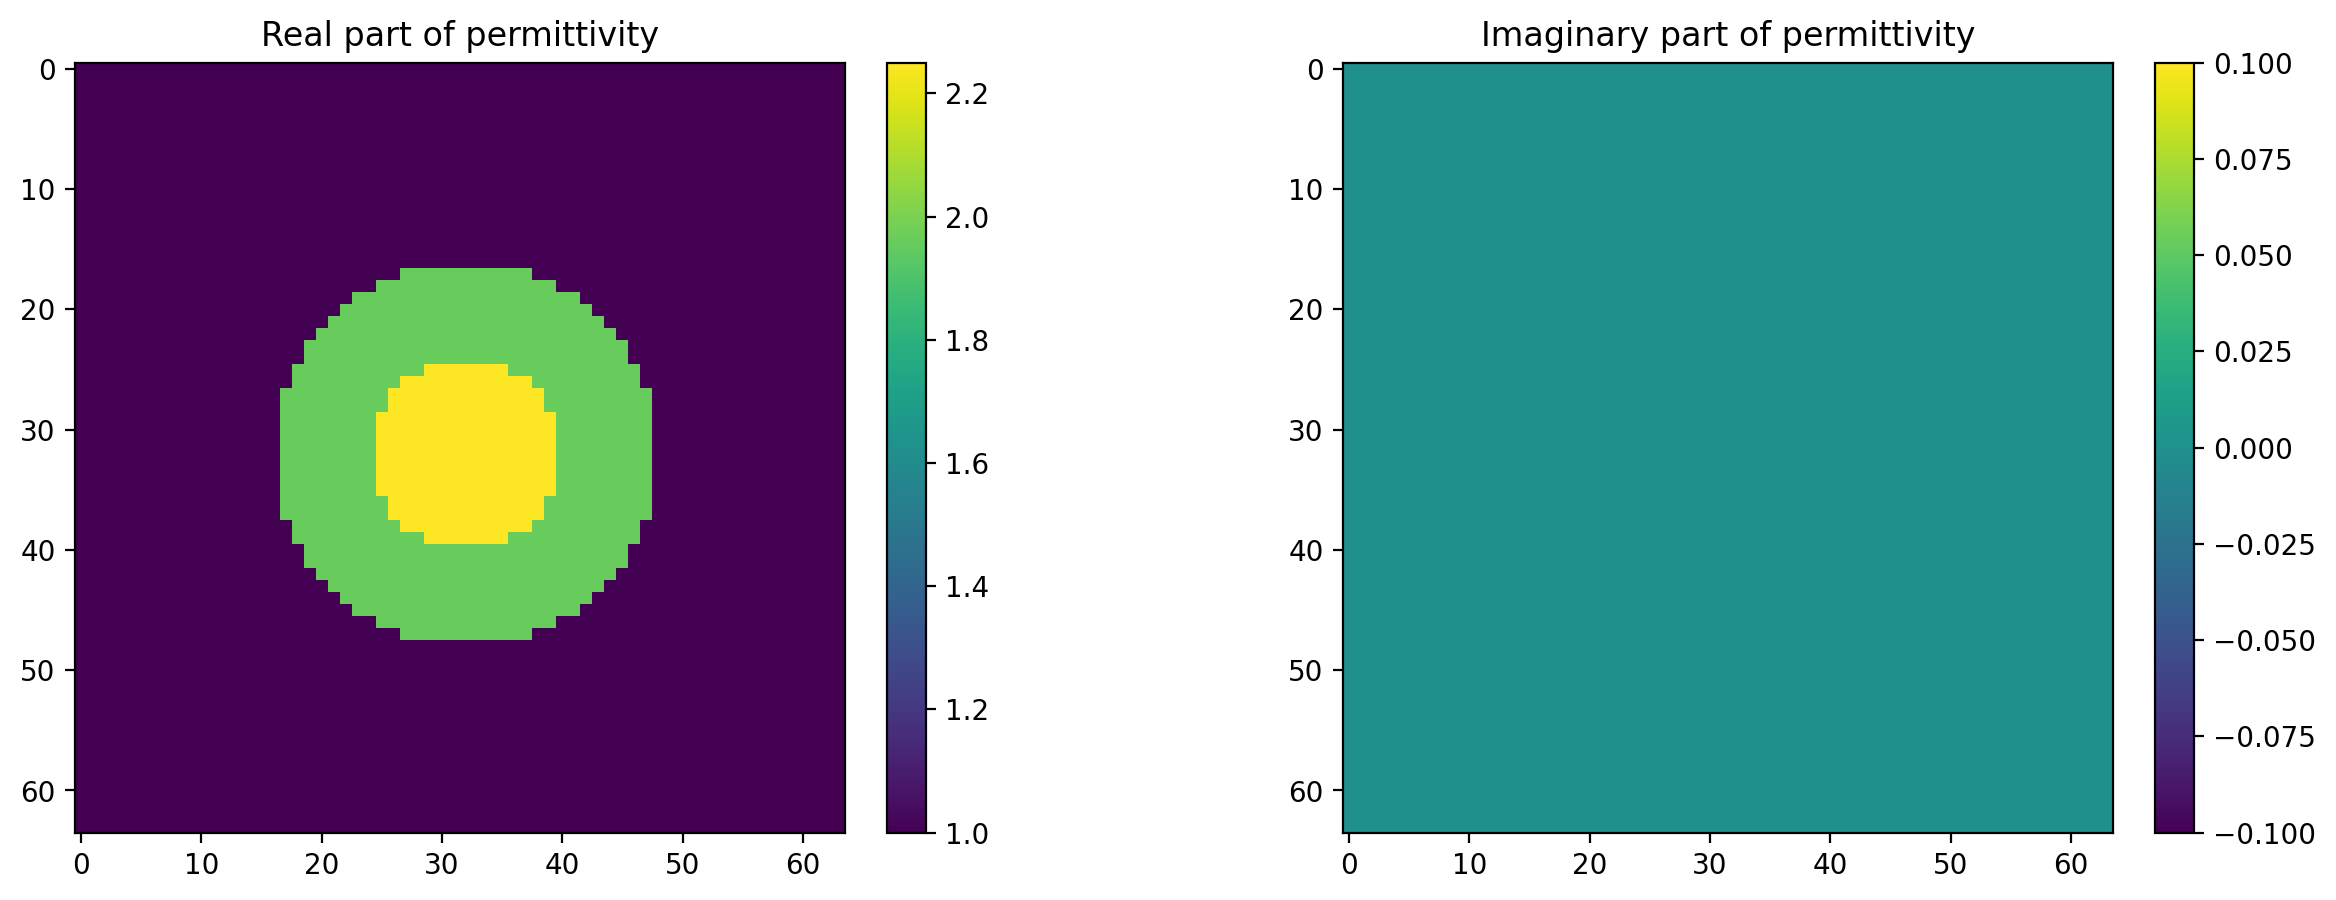

In [61]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.title("Real part of permittivity")
plt.imshow(sample.permittivity[:, grid_shape[1] // 2, :].real)

plt.colorbar(fraction=0.046, pad=0.04)


plt.subplot(122)
plt.title("Imaginary part of permittivity")
plt.imshow(sample.permittivity[:, grid_shape[1] // 2, :].imag)

plt.colorbar(fraction=0.046, pad=0.04)

In [62]:
print(sample.permittivity.shape)
print(sample.shape)
print(grid_shape)
print(object.shape)

(64, 168, 64)
(64, 168, 64)
[64, 128, 64]
(64, 128, 64)


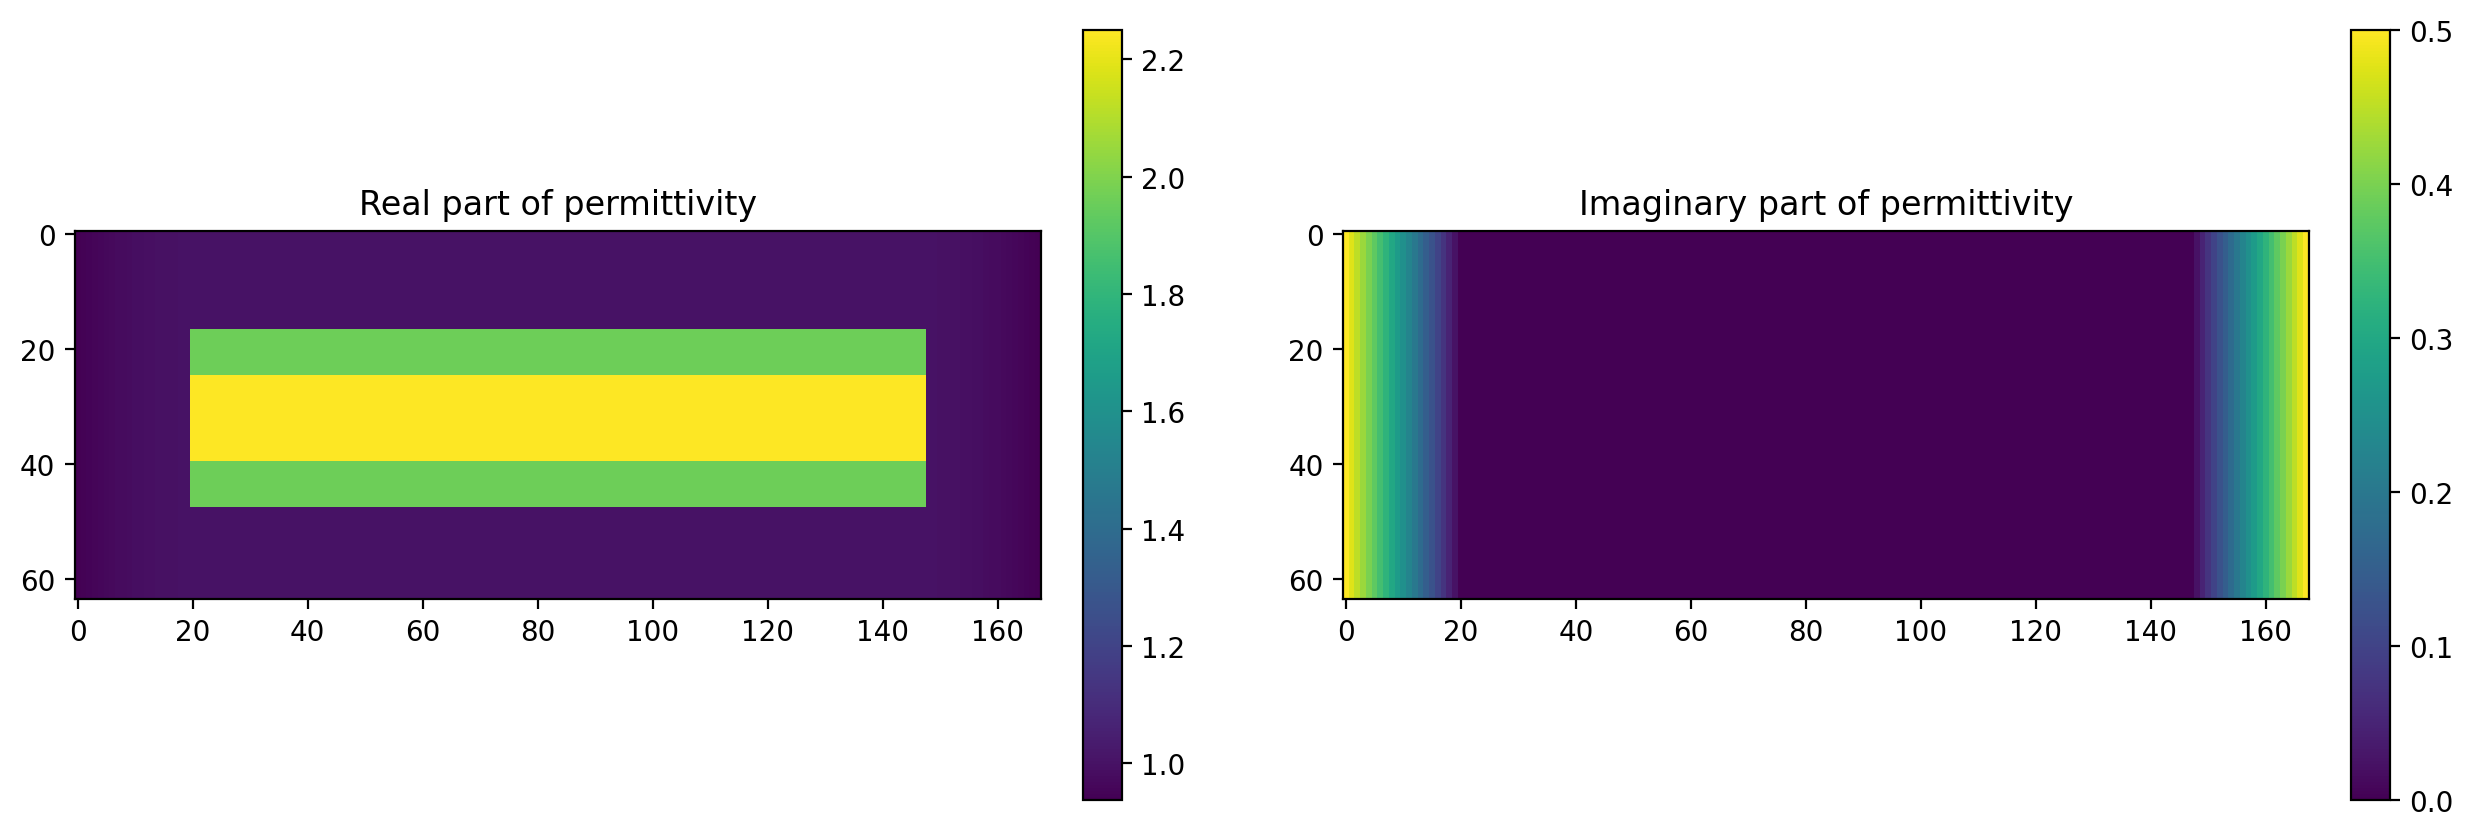

In [63]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.title("Real part of permittivity")
plt.imshow(sample.permittivity[grid_shape[0] // 2, :, :].T.real)

plt.colorbar(fraction=0.046, pad=0.04)


plt.subplot(122)
plt.title("Imaginary part of permittivity")
plt.imshow(sample.permittivity[grid_shape[0] // 2, :, :].T.imag)

plt.colorbar(fraction=0.046, pad=0.04)
# TODO special bound conditions where the real extends into the boundaries (treat fiber as infinite)
# TODO make sure long absorbing boundary at other side (very little power

Text(0.5, 0.98, 'cross-section at relevant index (26)')

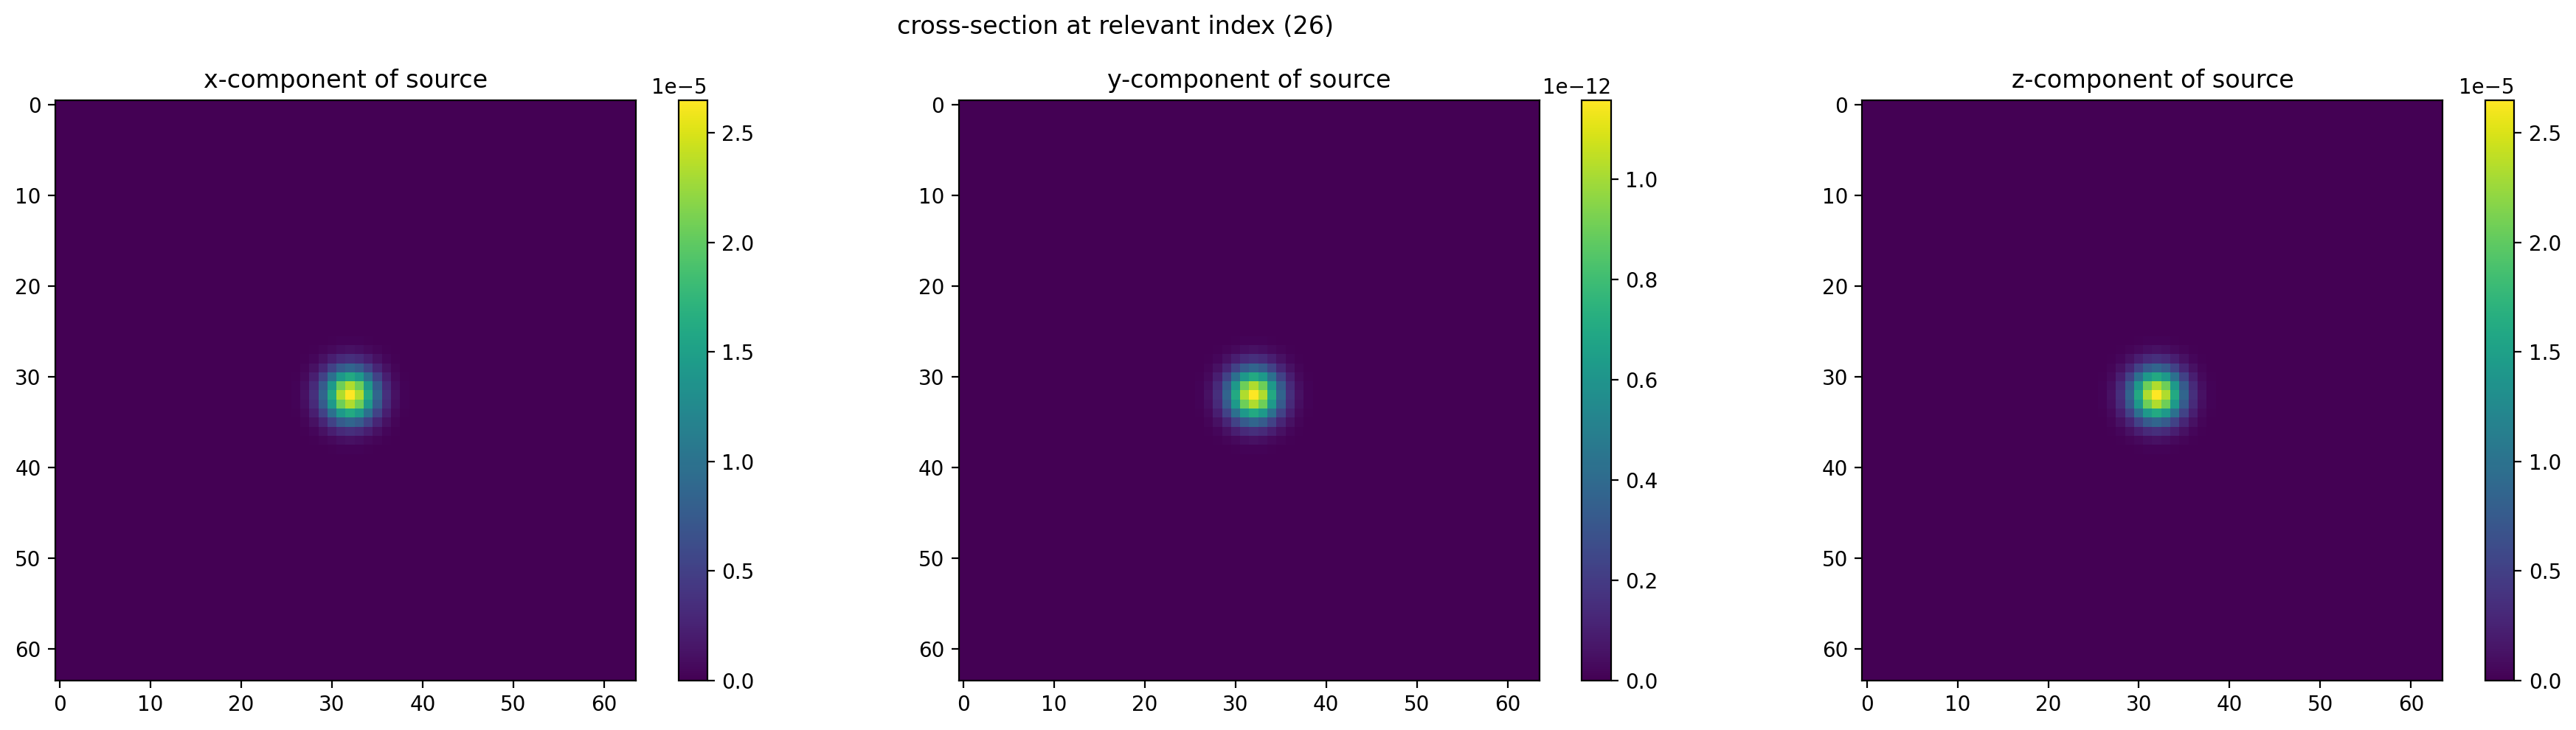

In [64]:
# Making the source
incident_angle = 1.0 / 2.0 * jnp.pi


def rot_Z(a):
    return jnp.array(
        [[jnp.cos(a), -jnp.sin(a), 0], [jnp.sin(a), jnp.cos(a), 0], [0, 0, 1]]
    )


incident_k = rot_Z(incident_angle) * k0 @ jnp.array([1, 0, 0])
source_polarization = rot_Z(incident_angle) @ jnp.array([0, 1, 1j]) / jnp.sqrt(2)

# Current density
beam_radius = (sample.extent[0] / 16) / 2
source_pixel_index = int(2.0 / sample.spacing) + mbs_boundary_width
grid = sample.grid[:, source_pixel_index]

current_density = jnp.exp(
    1j * jnp.sum(grid * incident_k, axis=-1)
)  # x z -- want z only
current_density = current_density * jnp.exp(
    # -0.5 * ((grid[..., 0] - object_radius/2.0) / beam_radius) ** 2
    -0.5 * (jnp.sqrt(grid[..., 0] ** 2 + grid[..., 2] ** 2) / beam_radius) ** 2
)
current_density = source_polarization * current_density[..., None]
current_density = (
    jnp.zeros((*sample.shape, 3), dtype=jnp.complex64)
    .at[:, source_pixel_index]
    .set(current_density)
)
source = Source(current_density, k0)


plt.figure(figsize=(20, 5), layout="tight")
plt.subplot(131)
plt.title("x-component of source")
plt.imshow(jnp.abs(source.field[:, source_pixel_index, :, 0]))
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(132)
plt.title("y-component of source")
plt.imshow(jnp.abs(source.field[:, source_pixel_index, :, 1]))
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(133)
plt.title("z-component of source")
plt.imshow(jnp.abs(source.field[:, source_pixel_index, :, 2]))
plt.colorbar(fraction=0.046, pad=0.04)
plt.suptitle("cross-section at relevant index (" + str(source_pixel_index) + ")")

In [65]:
# Actually solving
E = eqx.filter_jit(solve)(sample, source)
E = E[sample.ROI]  # extract ROI, we don't care about boundaries

In [66]:
import jax

print(eqx.__version__)

0.12.2


In [67]:
print(jax.__version__)

0.6.1


Text(0.5, 0.98, "Central slice of fiber, cropped to cladding and pixel after source's plane")

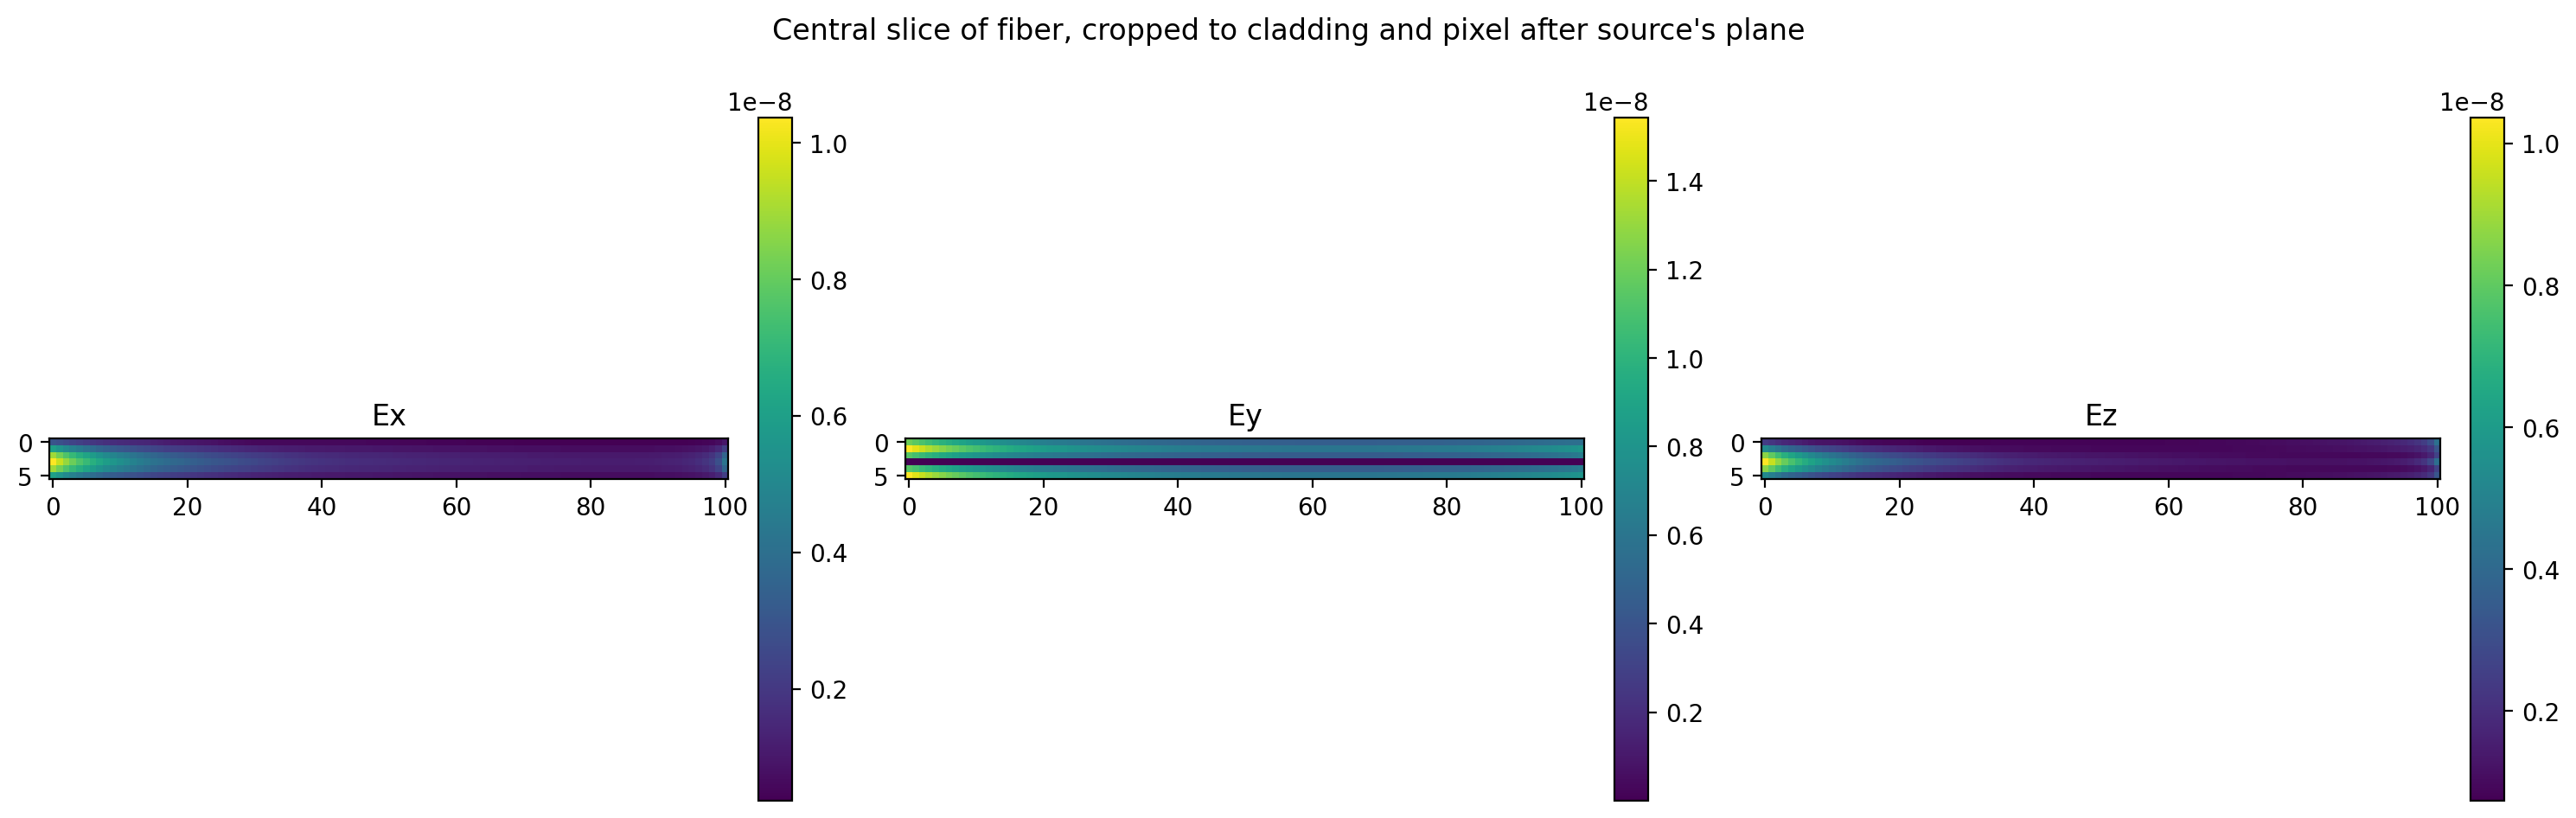

In [73]:
plt.figure(figsize=(15, 5), layout="tight")
hw = int(
    jnp.ceil(
        material_cylinder_radius_arr[0]
        * (sample.extent[0] / 2)
        / 2
        * material_cylinder_radius_arr[i]
    )
)


plt.subplot(131)
plt.title("Ex")
plt.imshow(
    jnp.abs(E)[
        grid_shape[0] // 2,
        source_pixel_index + 1 :,
        grid_shape[2] // 2 - hw : grid_shape[2] // 2 + hw,
        0,
    ].T
)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(132)
plt.title("Ey")
plt.imshow(
    jnp.abs(E)[
        grid_shape[0] // 2,
        source_pixel_index + 1 :,
        grid_shape[2] // 2 - hw : grid_shape[2] // 2 + hw,
        1,
    ].T
)
plt.colorbar(fraction=0.046, pad=0.04)


plt.subplot(133)
plt.title("Ez")
plt.imshow(
    jnp.abs(E)[
        grid_shape[0] // 2,
        source_pixel_index + 1 :,
        grid_shape[2] // 2 - hw : grid_shape[2] // 2 + hw,
        2,
    ].T
)
plt.colorbar(fraction=0.046, pad=0.04)

plt.suptitle(
    "Central slice of fiber, cropped to cladding and pixel after source's plane"
)

Text(0.5, 0.98, 'Central slice of fiber, cropped to core')

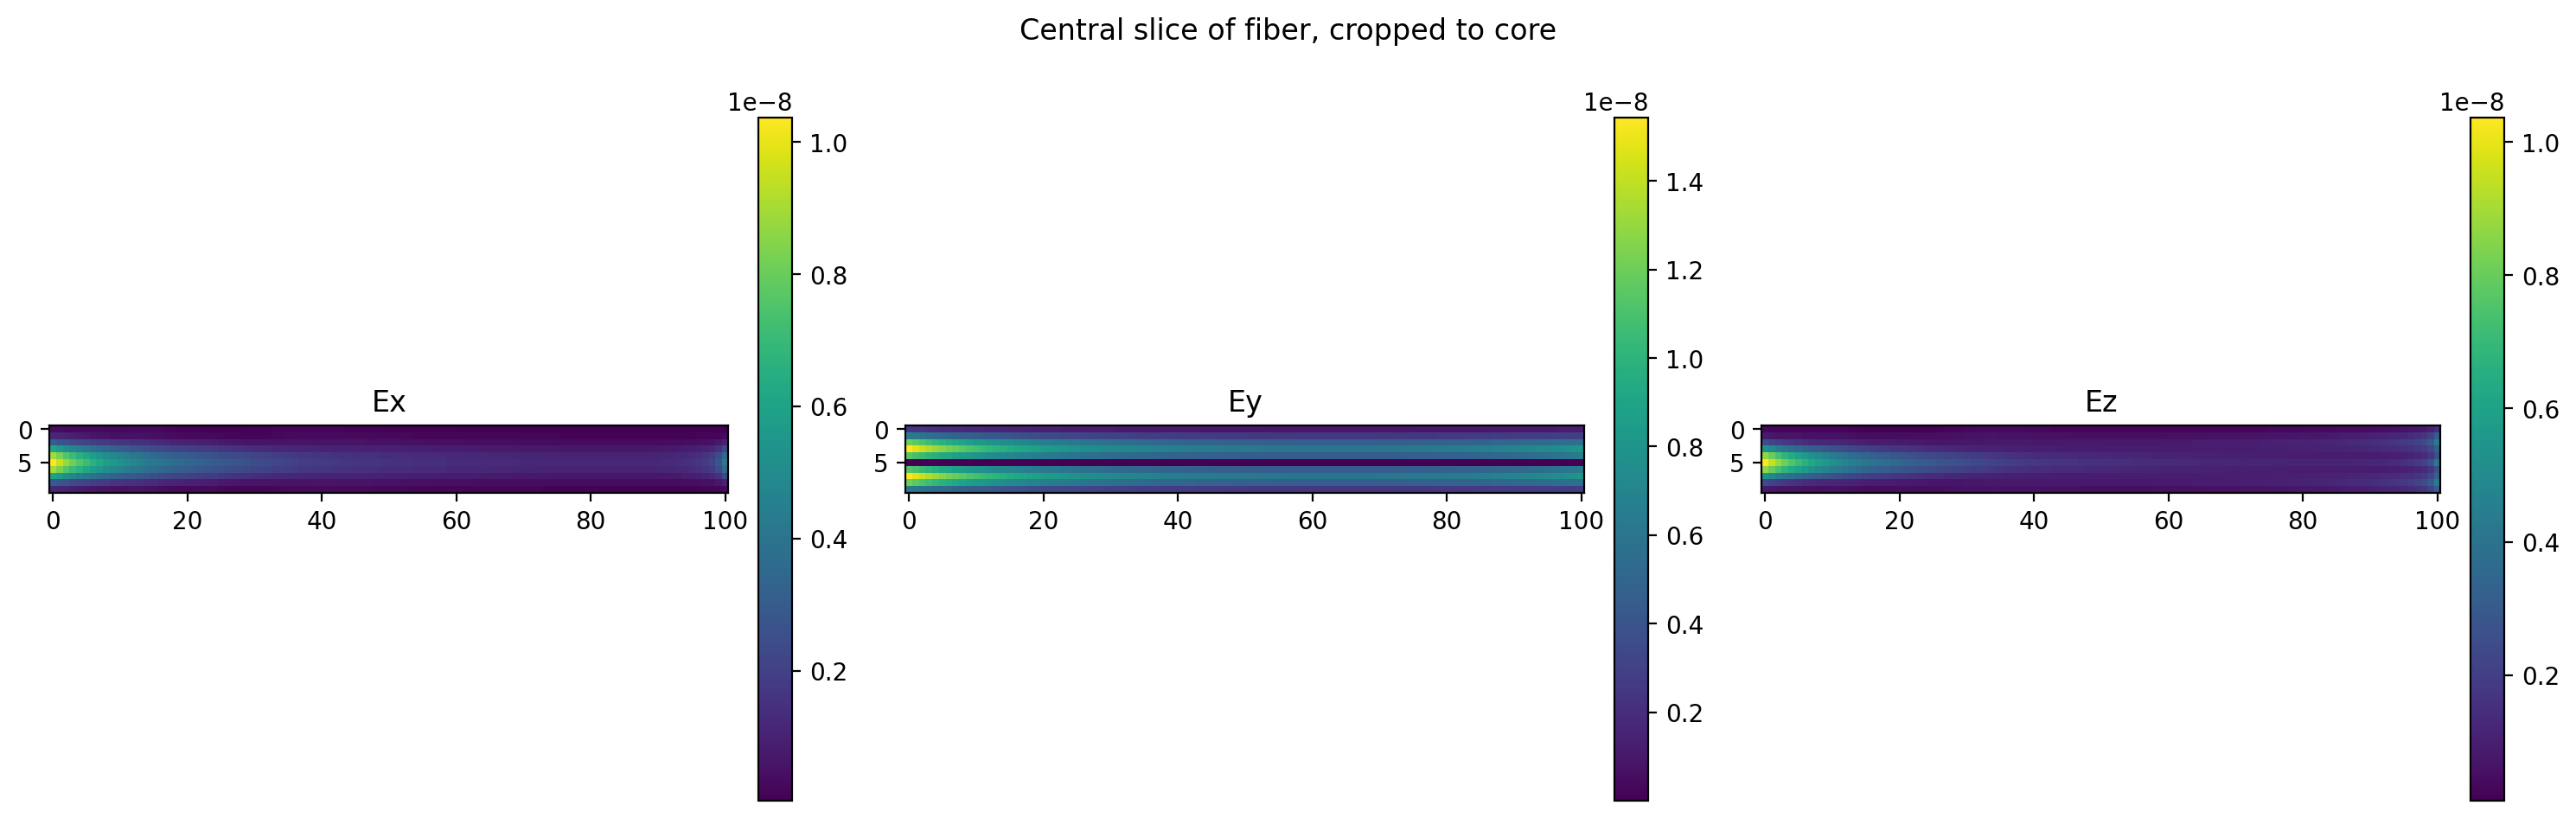

In [74]:
plt.figure(figsize=(15, 5), layout="tight")
hw = int(
    jnp.ceil(
        material_cylinder_radius_arr[1]
        * (sample.extent[0] / 2)
        / 2
        * material_cylinder_radius_arr[i]
    )
)

plt.subplot(131)
plt.title("Ex")
plt.imshow(
    jnp.abs(E)[
        grid_shape[0] // 2,
        source_pixel_index + 1 :,
        grid_shape[2] // 2 - hw : grid_shape[2] // 2 + hw,
        0,
    ].T
)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(132)
plt.title("Ey")
plt.imshow(
    jnp.abs(E)[
        grid_shape[0] // 2,
        source_pixel_index + 1 :,
        grid_shape[2] // 2 - hw : grid_shape[2] // 2 + hw,
        1,
    ].T
)
plt.colorbar(fraction=0.046, pad=0.04)


plt.subplot(133)
plt.title("Ez")
plt.imshow(
    jnp.abs(E)[
        grid_shape[0] // 2,
        source_pixel_index + 1 :,
        grid_shape[2] // 2 - hw : grid_shape[2] // 2 + hw,
        2,
    ].T
)
plt.colorbar(fraction=0.046, pad=0.04)

plt.suptitle("Central slice of fiber, cropped to core")

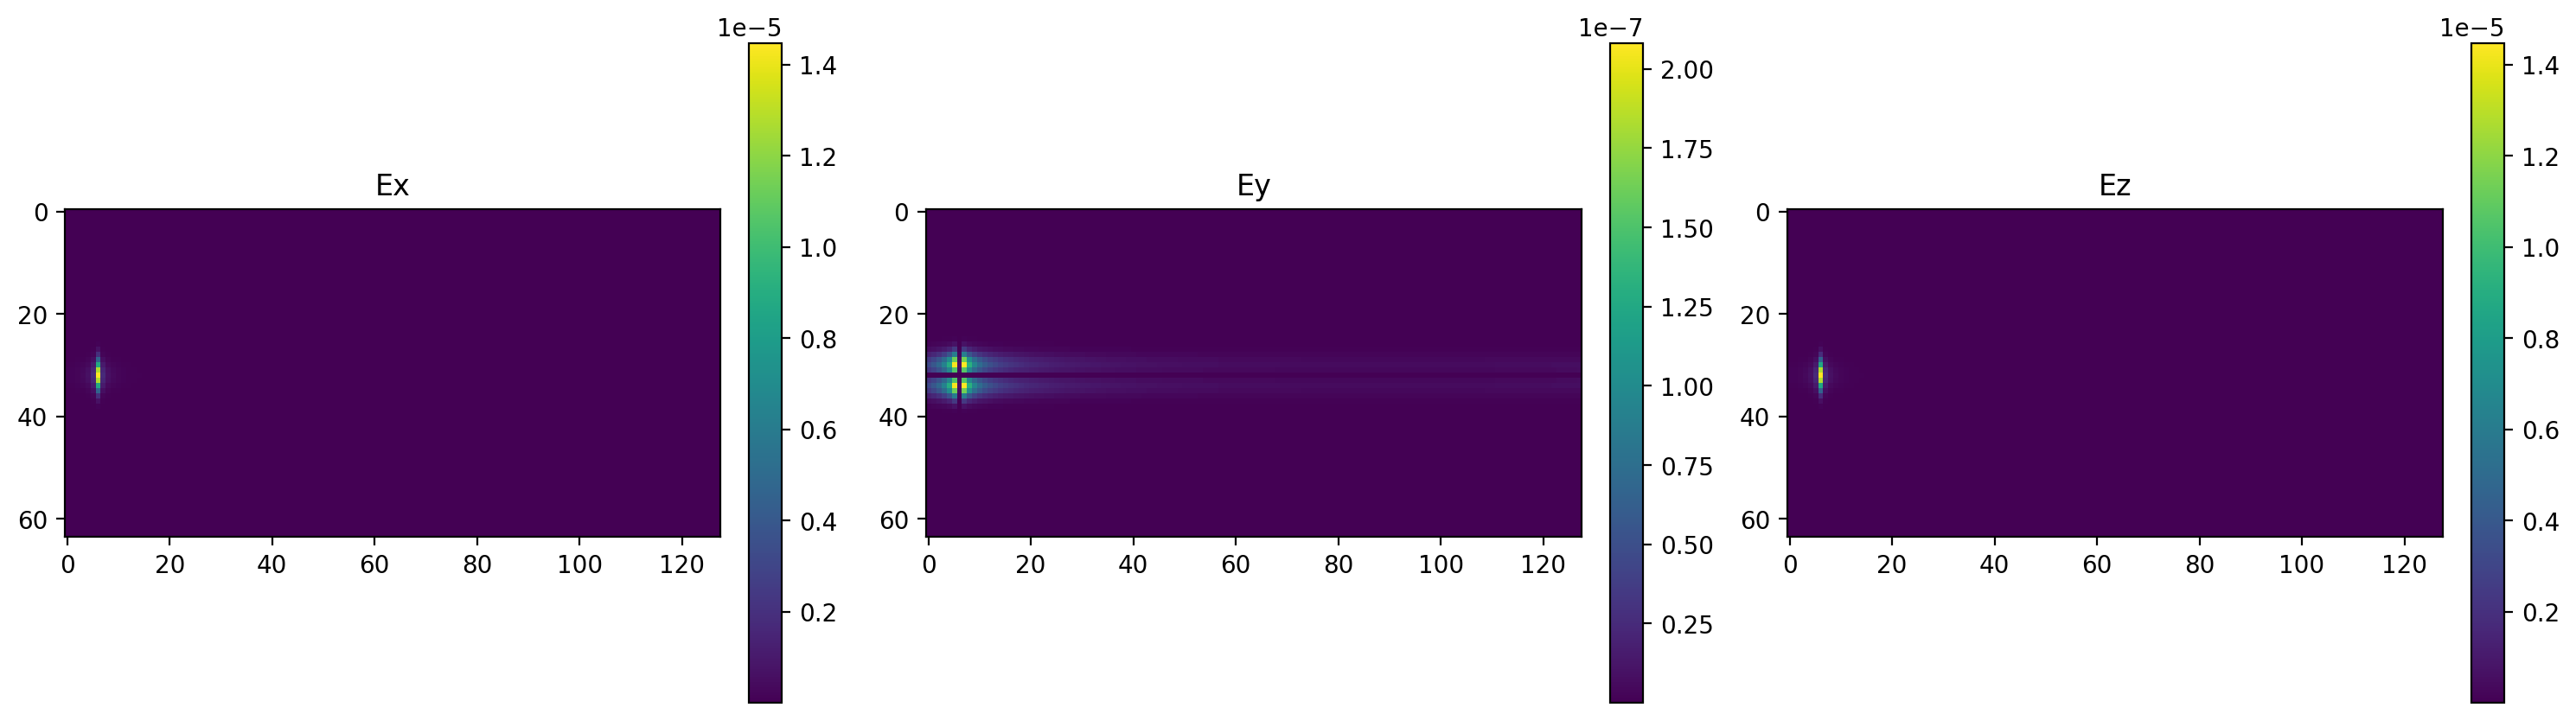

In [70]:
plt.figure(figsize=(15, 5), layout="tight")


plt.subplot(131)
plt.title("Ex")
plt.imshow(jnp.abs(E)[:, :, grid_shape[2] // 2, 0])
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(132)
plt.title("Ey")
plt.imshow(jnp.abs(E)[:, :, grid_shape[2] // 2, 1])
plt.colorbar(fraction=0.046, pad=0.04)


plt.subplot(133)
plt.title("Ez")
plt.imshow(jnp.abs(E)[:, :, grid_shape[2] // 2, 2])
plt.colorbar(fraction=0.046, pad=0.04)

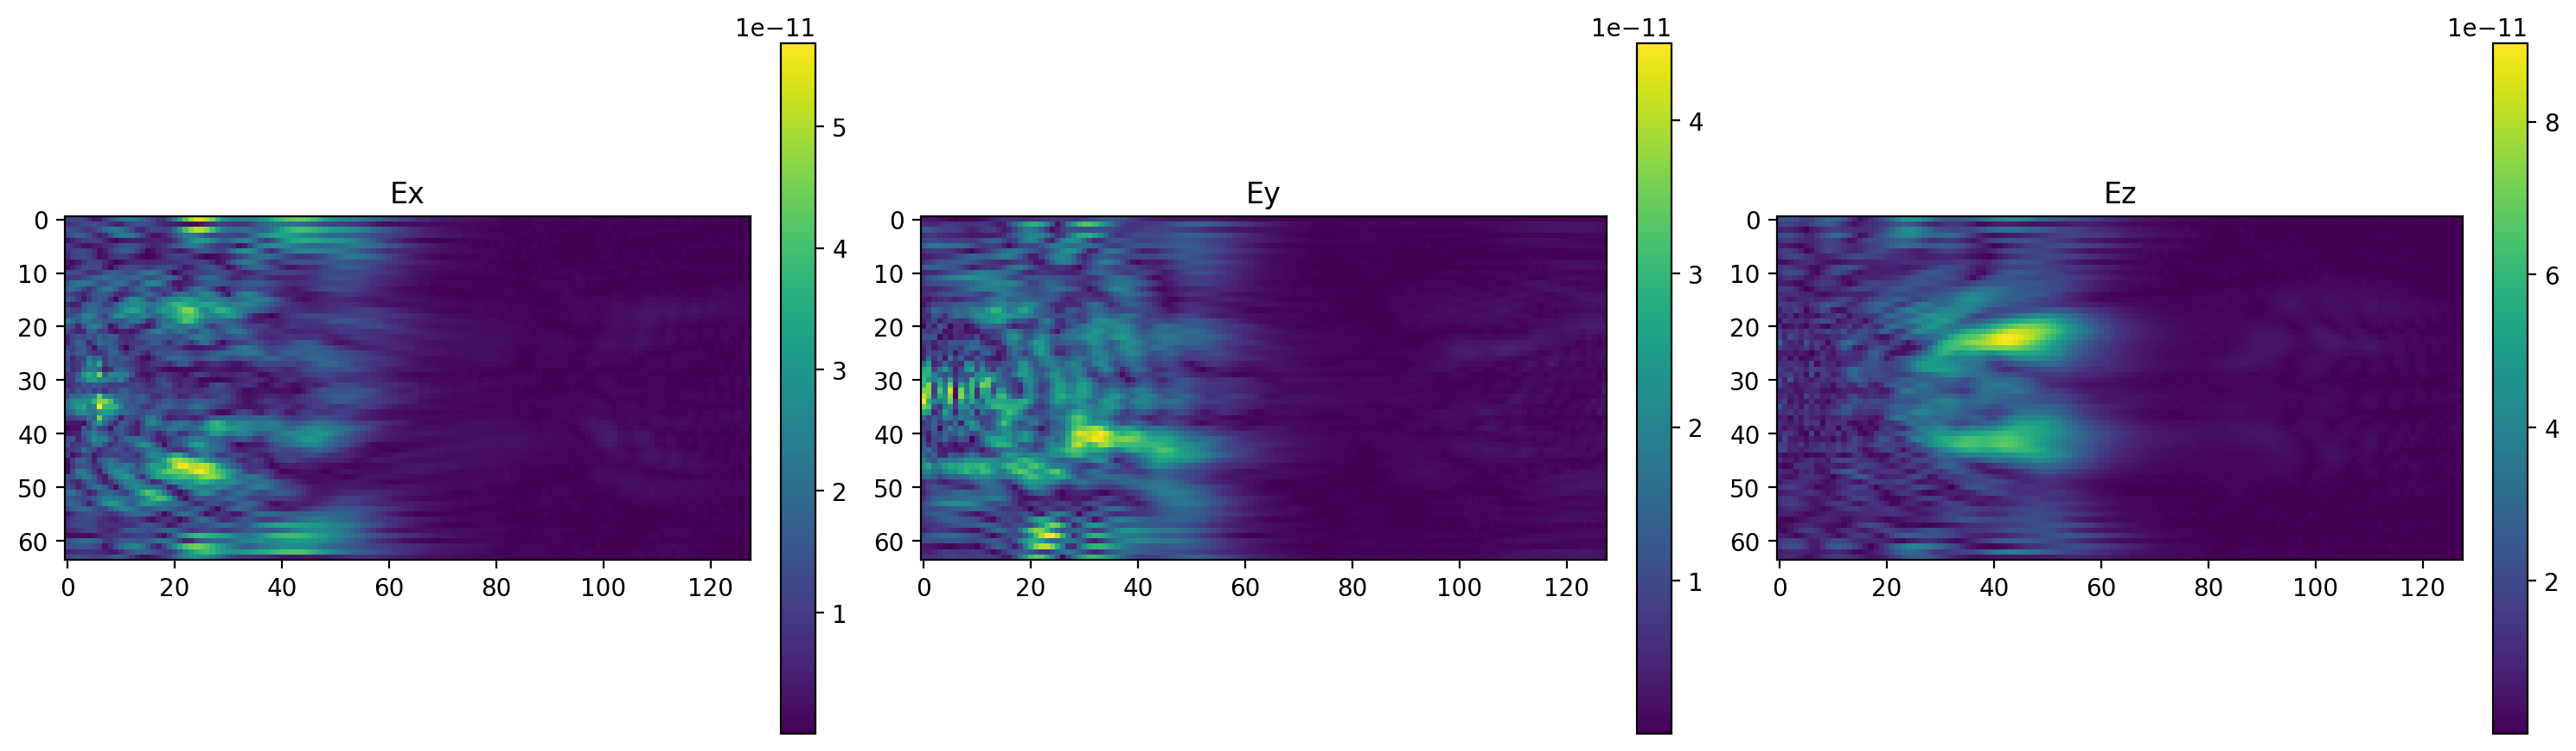

In [71]:
plt.figure(figsize=(15, 5), layout="tight")


plt.subplot(131)
plt.title("Ex")
plt.imshow(jnp.abs(E)[:, :, 0, 0])
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(132)
plt.title("Ey")
plt.imshow(jnp.abs(E)[:, :, 0, 1])
plt.colorbar(fraction=0.046, pad=0.04)


plt.subplot(133)
plt.title("Ez")
plt.imshow(jnp.abs(E)[:, :, 0, 2])
plt.colorbar(fraction=0.046, pad=0.04)